### Importing Libs

In [2]:
import os
import shutil

import pandas as pd
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import (
    GRU,
    Conv1D,
    Dense,
    Embedding,
    Flatten,
    Input,
    Lambda,
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical

2023-05-19 09:25:50.201505: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-19 09:25:50.253019: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-19 09:25:50.254762: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-19 09:25:51.393832: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
%matplotlib inline

In [7]:
LOGDIR = "./text_models"
DATA_DIR = "../datasets"

### Load data

In [8]:
DATASET_NAME = "titles_full.csv"
TITLE_SAMPLE_PATH = os.path.join(DATA_DIR, DATASET_NAME)
COLUMNS = ["title", "source"]

titles_df = pd.read_csv(TITLE_SAMPLE_PATH, header=None, names=COLUMNS)
titles_df.head()

,title,source
0,holy cash cow batman - content is back,nytimes
1,show hn a simple and configurable deployment ...,github
2,show hn neural turing machine in pure numpy. ...,github
3,close look at a flu outbreak upends some commo...,nytimes
4,lambdalite a functional relational lisp data...,github


### Tokenizer

In [11]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(titles_df.title)

In [12]:
integerized_titles = tokenizer.texts_to_sequences(titles_df.title)
integerized_titles[:3]

[[6117, 560, 8577, 13948, 302, 13, 172],
 [11, 12, 2, 49, 7, 3838, 1322, 91, 4, 28, 482],
 [11, 12, 1501, 2812, 322, 5, 589, 7337, 5458, 78, 108, 1989, 17, 1139]]

In [13]:
VOCAB_SIZE = len(tokenizer.index_word)
VOCAB_SIZE

47271

In [14]:
DATASET_SIZE = tokenizer.document_count
DATASET_SIZE

96203

In [15]:
MAX_LEN = max(len(sequence) for sequence in integerized_titles)
MAX_LEN

26

In [16]:
def create_sequences(texts, max_len=MAX_LEN):
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, max_len, padding="post")
    return padded_sequences

In [17]:
sequences = create_sequences(titles_df.title[:3])
sequences

array([[ 6117,   560,  8577, 13948,   302,    13,   172,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0],
       [   11,    12,     2,    49,     7,  3838,  1322,    91,     4,
           28,   482,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0],
       [   11,    12,  1501,  2812,   322,     5,   589,  7337,  5458,
           78,   108,  1989,    17,  1139,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0]],
      dtype=int32)

In [18]:
CLASSES = {"github": 0, "nytimes": 1, "techcrunch": 2}
N_CLASSES = len(CLASSES)

In [19]:
def encode_labels(sources):
    classes = [CLASSES[source] for source in sources]
    one_hots = to_categorical(classes)
    return one_hots

In [20]:
encode_labels(titles_df.source[:4])

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.]], dtype=float32)

### Data Prep

In [21]:
N_TRAIN = int(DATASET_SIZE * 0.80)

titles_train, sources_train = (
    titles_df.title[:N_TRAIN],
    titles_df.source[:N_TRAIN],
)

titles_valid, sources_valid = (
    titles_df.title[N_TRAIN:],
    titles_df.source[N_TRAIN:],
)

In [22]:
sources_train.value_counts()

github        29175
techcrunch    24784
nytimes       23003
Name: source, dtype: int64

In [23]:
sources_valid.value_counts()

github        7350
techcrunch    6107
nytimes       5784
Name: source, dtype: int64

In [25]:
X_train, Y_train = create_sequences(titles_train), encode_labels(sources_train)
X_valid, Y_valid = create_sequences(titles_valid), encode_labels(sources_valid)

### Building DNN model

In [27]:
def build_dnn_model(embed_dim):
    model = Sequential(
        [
            Embedding(
                VOCAB_SIZE + 1, embed_dim, input_shape=[MAX_LEN]
            ),  # TODO 3
            Lambda(lambda x: tf.reduce_mean(x, axis=1)),
            Dense(N_CLASSES, activation="softmax"),
        ]
    )

    model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

Epoch 1/100
257/257 [==============================] - 2s 7ms/step - loss: 1.0570 - accuracy: 0.4114 - val_loss: 0.9950 - val_accuracy: 0.5583
Epoch 2/100
257/257 [==============================] - 2s 6ms/step - loss: 0.9046 - accuracy: 0.6688 - val_loss: 0.8180 - val_accuracy: 0.7190
Epoch 3/100
257/257 [==============================] - 1s 6ms/step - loss: 0.7407 - accuracy: 0.7739 - val_loss: 0.6850 - val_accuracy: 0.7837
Epoch 4/100
257/257 [==============================] - 2s 6ms/step - loss: 0.6282 - accuracy: 0.8069 - val_loss: 0.5986 - val_accuracy: 0.8033
Epoch 5/100
257/257 [==============================] - 1s 6ms/step - loss: 0.5521 - accuracy: 0.8238 - val_loss: 0.5398 - val_accuracy: 0.8156
Epoch 6/100
257/257 [==============================] - 2s 6ms/step - loss: 0.4976 - accuracy: 0.8360 - val_loss: 0.4980 - val_accuracy: 0.8221
Epoch 7/100
257/257 [==============================] - 1s 6ms/step - loss: 0.4563 - accuracy: 0.8455 - val_loss: 0.4667 - val_accuracy: 0.8312

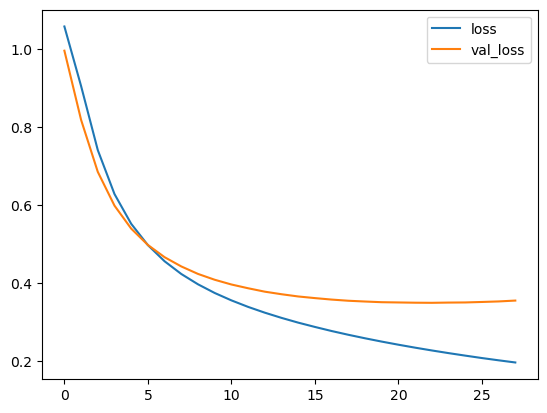

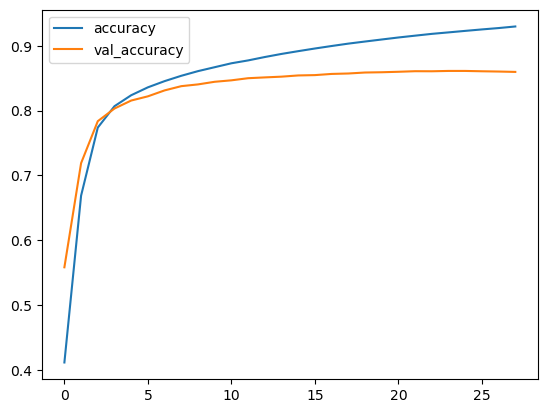

In [28]:
%%time

tf.random.set_seed(33)

MODEL_DIR = os.path.join(LOGDIR, "dnn")
shutil.rmtree(MODEL_DIR, ignore_errors=True)

BATCH_SIZE = 300
EPOCHS = 100
EMBED_DIM = 10
PATIENCE = 5

dnn_model = build_dnn_model(embed_dim=EMBED_DIM)

dnn_history = dnn_model.fit(
    X_train,
    Y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_valid, Y_valid),
    callbacks=[EarlyStopping(patience=PATIENCE), TensorBoard(MODEL_DIR)],
)

pd.DataFrame(dnn_history.history)[["loss", "val_loss"]].plot()
pd.DataFrame(dnn_history.history)[["accuracy", "val_accuracy"]].plot()

dnn_model.summary()

### Building RNN model

In [30]:
def build_rnn_model(embed_dim, units):
    model = Sequential(
        [
            Embedding(
                VOCAB_SIZE + 1, embed_dim, input_shape=[MAX_LEN], mask_zero=True
            ),  # TODO 3
            GRU(units),  # TODO 5
            Dense(N_CLASSES, activation="softmax"),
        ]
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

Epoch 1/100
257/257 [==============================] - 10s 29ms/step - loss: 1.0919 - accuracy: 0.3741 - val_loss: 1.0818 - val_accuracy: 0.3820
Epoch 2/100
257/257 [==============================] - 6s 23ms/step - loss: 1.0472 - accuracy: 0.4425 - val_loss: 0.9766 - val_accuracy: 0.5627
Epoch 3/100
257/257 [==============================] - 6s 23ms/step - loss: 0.8093 - accuracy: 0.6108 - val_loss: 0.7001 - val_accuracy: 0.6107
Epoch 4/100
257/257 [==============================] - 6s 23ms/step - loss: 0.6474 - accuracy: 0.6492 - val_loss: 0.6341 - val_accuracy: 0.6501
Epoch 5/100
257/257 [==============================] - 6s 21ms/step - loss: 0.5960 - accuracy: 0.6618 - val_loss: 0.6028 - val_accuracy: 0.6709
Epoch 6/100
257/257 [==============================] - 6s 23ms/step - loss: 0.5647 - accuracy: 0.7065 - val_loss: 0.5824 - val_accuracy: 0.7169
Epoch 7/100
257/257 [==============================] - 6s 22ms/step - loss: 0.5404 - accuracy: 0.7381 - val_loss: 0.5654 - val_accuracy

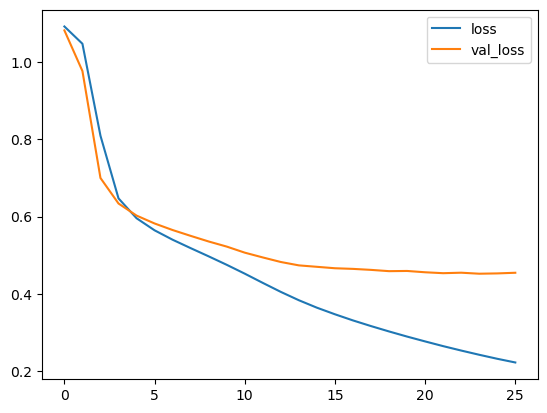

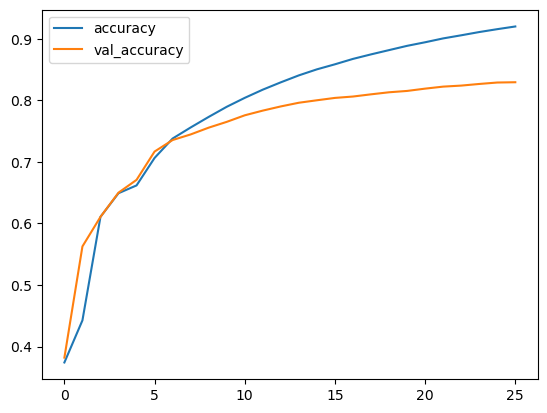

In [31]:
%%time

tf.random.set_seed(33)

MODEL_DIR = os.path.join(LOGDIR, "rnn")
shutil.rmtree(MODEL_DIR, ignore_errors=True)

EPOCHS = 100
BATCH_SIZE = 300
EMBED_DIM = 10
UNITS = 16
PATIENCE = 2

rnn_model = build_rnn_model(embed_dim=EMBED_DIM, units=UNITS)

history = rnn_model.fit(
    X_train,
    Y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_valid, Y_valid),
    callbacks=[EarlyStopping(patience=PATIENCE), TensorBoard(MODEL_DIR)],
)

pd.DataFrame(history.history)[["loss", "val_loss"]].plot()
pd.DataFrame(history.history)[["accuracy", "val_accuracy"]].plot()

rnn_model.summary()

### Building CNN model

In [33]:
def build_cnn_model(embed_dim, filters, ksize, strides):
    model = Sequential(
        [
            Embedding(
                VOCAB_SIZE + 1, embed_dim, input_shape=[MAX_LEN], mask_zero=True
            ), 
            Conv1D( 
                filters=filters,
                kernel_size=ksize,
                strides=strides,
                activation="relu",
            ),
            Flatten(), 
            Dense(N_CLASSES, activation="softmax"),
        ]
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

Epoch 1/100
257/257 [==============================] - 3s 8ms/step - loss: 1.0810 - accuracy: 0.4032 - val_loss: 1.0348 - val_accuracy: 0.5183
Epoch 2/100
257/257 [==============================] - 2s 7ms/step - loss: 0.8929 - accuracy: 0.5989 - val_loss: 0.7521 - val_accuracy: 0.6482
Epoch 3/100
257/257 [==============================] - 2s 7ms/step - loss: 0.6695 - accuracy: 0.6843 - val_loss: 0.6270 - val_accuracy: 0.6961
Epoch 4/100
257/257 [==============================] - 2s 7ms/step - loss: 0.5834 - accuracy: 0.7202 - val_loss: 0.5779 - val_accuracy: 0.7238
Epoch 5/100
257/257 [==============================] - 2s 7ms/step - loss: 0.5373 - accuracy: 0.7517 - val_loss: 0.5459 - val_accuracy: 0.7485
Epoch 6/100
257/257 [==============================] - 2s 8ms/step - loss: 0.5023 - accuracy: 0.7749 - val_loss: 0.5229 - val_accuracy: 0.7605
Epoch 7/100
257/257 [==============================] - 2s 7ms/step - loss: 0.4731 - accuracy: 0.7925 - val_loss: 0.5052 - val_accuracy: 0.7737

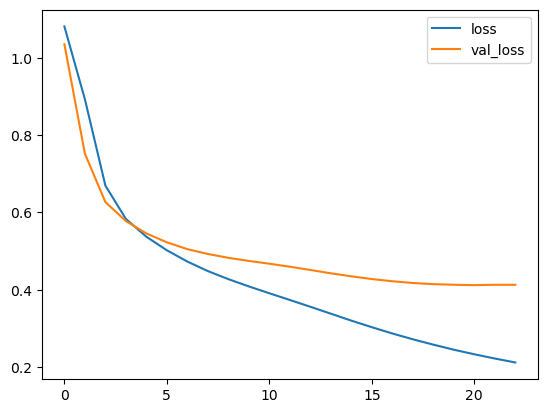

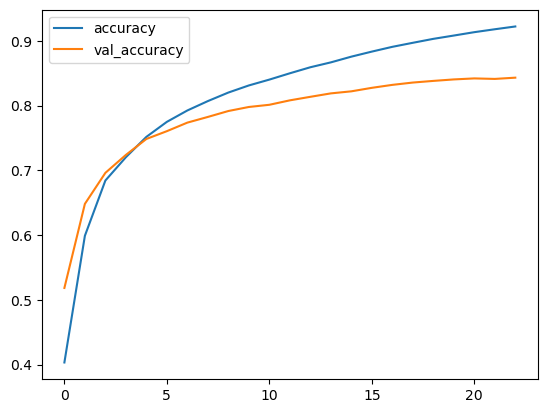

In [34]:
%%time

tf.random.set_seed(33)

MODEL_DIR = os.path.join(LOGDIR, "cnn")
shutil.rmtree(MODEL_DIR, ignore_errors=True)

EPOCHS = 100
BATCH_SIZE = 300
EMBED_DIM = 5
FILTERS = 200
STRIDES = 2
KSIZE = 3
PATIENCE = 2


cnn_model = build_cnn_model(
    embed_dim=EMBED_DIM,
    filters=FILTERS,
    strides=STRIDES,
    ksize=KSIZE,
)

cnn_history = cnn_model.fit(
    X_train,
    Y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_valid, Y_valid),
    callbacks=[EarlyStopping(patience=PATIENCE), TensorBoard(MODEL_DIR)],
)

pd.DataFrame(cnn_history.history)[["loss", "val_loss"]].plot()
pd.DataFrame(cnn_history.history)[["accuracy", "val_accuracy"]].plot()

cnn_model.summary()

### Keras Preprocessing Layer

In [36]:
from keras.layers import TextVectorization

In [37]:
MAX_LEN = 26
MAX_TOKENS = 20000
preprocessing_layer = TextVectorization(
    output_sequence_length=MAX_LEN, max_tokens=MAX_TOKENS
)

In [38]:
titles_df.head()

,title,source
0,holy cash cow batman - content is back,nytimes
1,show hn a simple and configurable deployment ...,github
2,show hn neural turing machine in pure numpy. ...,github
3,close look at a flu outbreak upends some commo...,nytimes
4,lambdalite a functional relational lisp data...,github


In [39]:
preprocessing_layer.adapt(titles_df.title)

In [40]:
X_train, X_valid = titles_train, titles_valid
X_train[:5]

0              holy cash cow  batman - content is back
1    show hn  a simple and configurable deployment ...
2    show hn  neural turing machine in pure numpy. ...
3    close look at a flu outbreak upends some commo...
4    lambdalite  a functional  relational lisp data...
Name: title, dtype: object

In [41]:
integers = preprocessing_layer(X_train[:5])
integers

<tf.Tensor: shape=(5, 26), dtype=int64, numpy=
array([[ 6236,   538,  9221,     1,   295,    14,   162,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0],
       [   12,    13,     4,    47,     8,  3862,  1252,    79,     5,
           30,   454,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0],
       [   12,    13,  1484,  2853,   315,     6,   584,  8144,  5553,
           75,   242,  1942,    18,  1169,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0],
       [ 1034,   304,    23,     4,  3713,  7509, 14383,   199,   678,
         4512,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0],
       [    1,     4,   604,  4221,   553,   280,     6,  2052,   491,
            7,   678,   553,     0,     0,     0,     

In [42]:
def build_model_with_text_preprocessing(embed_dim, units):
    model = Sequential(
        [
            Input(shape=(1,), dtype=tf.string),
            preprocessing_layer,
            Embedding(
                VOCAB_SIZE + 1, embed_dim, input_shape=[MAX_LEN], mask_zero=True
            ),
            GRU(units),
            Dense(N_CLASSES, activation="softmax"),
        ]
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [44]:
model = build_model_with_text_preprocessing(embed_dim=EMBED_DIM, units=UNITS)
model.predict(X_train[:5])

1/1 [==============================] - 1s 943ms/step


array([[0.3349434 , 0.32776856, 0.33728802],
       [0.3350134 , 0.33664978, 0.32833686],
       [0.3308791 , 0.33618605, 0.3329348 ],
       [0.32957253, 0.33755642, 0.33287108],
       [0.33607662, 0.33173886, 0.33218452]], dtype=float32)

Epoch 1/100
257/257 [==============================] - 10s 24ms/step - loss: 1.0907 - accuracy: 0.3794 - val_loss: 1.0790 - val_accuracy: 0.3842
Epoch 2/100
257/257 [==============================] - 5s 19ms/step - loss: 1.0347 - accuracy: 0.4658 - val_loss: 0.9417 - val_accuracy: 0.5616
Epoch 3/100
257/257 [==============================] - 5s 19ms/step - loss: 0.7896 - accuracy: 0.6159 - val_loss: 0.7014 - val_accuracy: 0.6371
Epoch 4/100
257/257 [==============================] - 5s 18ms/step - loss: 0.6560 - accuracy: 0.6486 - val_loss: 0.6403 - val_accuracy: 0.6493
Epoch 5/100
257/257 [==============================] - 5s 18ms/step - loss: 0.6080 - accuracy: 0.6606 - val_loss: 0.6091 - val_accuracy: 0.6721
Epoch 6/100
257/257 [==============================] - 5s 18ms/step - loss: 0.5780 - accuracy: 0.6964 - val_loss: 0.5875 - val_accuracy: 0.7081
Epoch 7/100
257/257 [==============================] - 5s 18ms/step - loss: 0.5546 - accuracy: 0.7247 - val_loss: 0.5700 - val_accuracy

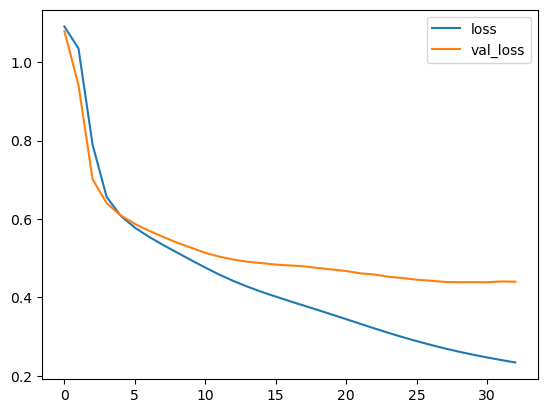

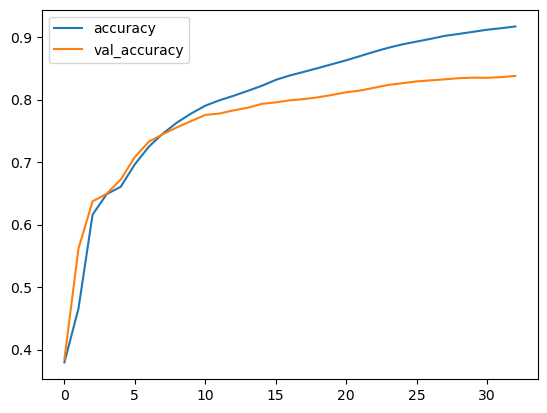

In [45]:
%%time

tf.random.set_seed(33)

MODEL_DIR = os.path.join(LOGDIR, "rnn")
shutil.rmtree(MODEL_DIR, ignore_errors=True)

EPOCHS = 100
BATCH_SIZE = 300
EMBED_DIM = 10
UNITS = 16
PATIENCE = 2

model = build_model_with_text_preprocessing(embed_dim=EMBED_DIM, units=UNITS)

history = model.fit(
    X_train,
    Y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_valid, Y_valid),
    callbacks=[EarlyStopping(patience=PATIENCE), TensorBoard(MODEL_DIR)],
)

pd.DataFrame(history.history)[["loss", "val_loss"]].plot()
pd.DataFrame(history.history)[["accuracy", "val_accuracy"]].plot()

model.summary()